In [1120]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [628]:
class Gridworld:

    def __init__(self, shape=(14,14), num_negative_tiles=0, starting_point=(1,1),num_walls=10):

        self.size = shape
        self.num_negative_tiles = num_negative_tiles
        self.current_state = np.array(starting_point)
        self.grid=None
        self.stochastic_transistions = np.zeros(shape=(shape[0]-1,shape[1]-1), dtype=np.float32)
        self.goal = np.array((shape[0]-2, shape[1]-2))
        self.acc_reward = 0 
        self.generate_world(num_walls)
        
    def generate_world(self, num_walls):
        valid_grid = False
        while not valid_grid:
            self.grid = self.generate_grid()
            unique_wall_indexes = False
            while not unique_wall_indexes:
                random_walls = np.random.randint(1,self.size[0]-1,size=(num_walls,2))
                random_walls_unique = np.unique(random_walls,axis=0)
                # check that the indeces neither describe the starting point nor the goal state or are doubled
                if len(random_walls) == len(random_walls_unique) and not tuple(self.goal) in random_walls.tolist() and not tuple(self.current_state) in random_walls.tolist():
                    unique_wall_indexes = True
            # apply for all unique indexes 
            for r in random_walls:
                self.grid[r[0],r[1]] = -100
            valid_grid = self.grid_is_valid()
    
    def generate_grid(self):
        grid = np.zeros(self.size, dtype=np.int64)
        grid[self.goal[0]][self.goal[1]] = 100
        grid[0,:] = -100
        grid[self.size[1]-1,:] = -100
        grid[:,0] = -100
        grid[:,self.size[1]-1] = -100
        return grid

          
    # depth first search to find out if the generated grid world is valid i.e there is a path from start to goal
    def grid_is_valid(self):
        visited = []
        visited = self.dfs(visited, self.current_state)     
        return np.any(np.all(self.goal == visited, axis=1))

    def dfs(self, visited, node):
        visited.append(node)
        neighbors = self.get_neighbors(node)
        for neighbor in neighbors:
            if not np.any(np.all(neighbor == np.array(visited), axis=1)):
            # neighbor is not in visited
                if self.grid[neighbor[0]][neighbor[1]] != -100:
                # neighbor is not a wall
                    self.dfs(visited, neighbor)
        return visited
            
    def get_neighbors(self, node):
        # edges in the same order as the step function, important !!!
        edges = [(0,1), (0,-1), (-1,0), (1,0)]
        neighbors = []
        for edge in edges:
            neighbor = (node[0] + edge[0], node[1] + edge[1])
            neighbors.append(np.array(neighbor))
        return neighbors      
        
    # reset the actor to starting state
    def reset(self):
        self.current_state = (1,1)
        self.acc_reward = 0
        
    # print the gridworld as an array 
    def visualize(self):
        print(self.grid)


In [1021]:
class SarsAgent:
    def __init__(self, grid_world, state, epsilon=0.9, alpha=0.01, gamma=0.95):
        self.learning_rate = alpha
        self.discount_factor = gamma
        self.epsilon = epsilon
        self.current_state = state
        self.grid_world = grid_world
        self.size = tuple(np.append(np.array(grid_world.size), np.array(4)))
        self.q_table = np.zeros((self.size), dtype=np.float32)
        
    def get_reward(self,state):
        return self.grid_world.grid[state[0]][state[1]]
    
    def get_valid_actions(self, state):
        # get a list of all actions we can do for the next step
        actions = []
        grid = self.grid_world
        neighbors = grid.get_neighbors(state)
        for idx, neighbor in enumerate(neighbors):
            # if neighbor is not a wall, add action to move there as valid
            if grid.grid[neighbor[0]][neighbor[1]] != -100:
                actions.append(idx)
        return actions
      
    def choose_action(self, state):
        # choose the next action for the agent
        
        actions = self.get_valid_actions(state)
        #print(f'actions: {actions}')
        
        # choose random action
        if np.random.uniform(0,1) < self.epsilon:
            action = np.random.choice(actions)
        # choose highest q-value action
        else:
            valid_states = {}
            for i in actions:
                valid_states[i] = (self.q_table[state][i])
                
            #print(f'valid_states:{valid_states}')
            
            # argmax for dictionary
            action = max(valid_states, key=valid_states.get)
            
        #print(f'chosen action: {action}')
        return action
            
    def learn(self, n_steps):   
        # implement Sarasa (with n_steps)
        #self.current_state = self.grid_world.current_state
        state = self.current_state
        next_action = None
        rewards = 0
        for n in range(n_steps):
            # get discounted rewards 
            reward = self.get_reward(state) * (self.discount_factor** n)
            rewards += reward
            action = self.choose_action(state)
            
            if next_action == None:
            # save the first action to move 
                next_action = action
            
            # get the next state for n-step Sarsa
            state = self.do_fake_step(state, action)
            
        Q = self.q_table[tuple(self.current_state)][next_action] 
        final_q = self.q_table[state][action] * (self.discount_factor** n_steps)
        Q = rewards + final_q - Q
        
        self.q_table[tuple(self.current_state)][action] = Q 
        return next_action
    
    def move(self, action):
        # move the agent on the grid according to the given action
        self.current_state = self.do_fake_step(self.current_state, action)
        
    def do_fake_step(self, state, action):
        # get the next state according to the given action
        grid = self.grid_world.grid     
        edges = [(0,1), (0,-1), (-1,0), (1,0)]
        next_state = (state[0] + edges[action][0], state[1] + edges[action][1])
        return next_state
        
    def reset(self):
        # reset the agent for a new episode
        self.current_state = (1,1)
        
    

In [1022]:
grid = Gridworld()
#grid.step(0)
valid_states = grid.grid_is_valid()
grid.visualize()
#print(grid.stochastic_transistions)

[[-100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100]
 [-100 -100    0    0    0    0    0    0    0    0    0    0 -100 -100]
 [-100    0    0    0 -100    0    0    0    0    0 -100    0    0 -100]
 [-100    0    0    0    0    0    0    0    0    0    0    0    0 -100]
 [-100    0    0 -100    0    0    0    0    0    0    0    0    0 -100]
 [-100    0    0    0 -100    0    0    0    0    0    0    0    0 -100]
 [-100    0    0    0    0    0    0    0    0    0    0    0    0 -100]
 [-100    0    0    0    0    0    0    0    0    0    0    0    0 -100]
 [-100    0    0    0 -100    0    0    0 -100    0    0    0    0 -100]
 [-100    0    0    0    0    0    0    0    0    0    0 -100    0 -100]
 [-100    0    0    0    0    0    0    0    0    0    0    0    0 -100]
 [-100    0    0    0    0    0    0    0    0    0    0    0    0 -100]
 [-100    0    0    0 -100    0    0    0    0    0    0    0  100 -100]
 [-100 -100 -100 -100 -100 -100 -100 -100 -100 -100

In [1095]:
agent = SarsAgent(grid, grid.current_state)
episodes = 1500
results = []
for episode in range(episodes):
    agent.reset()
    i = 0
    #print(grid.current_state, tuple(grid.goal))
    while agent.current_state != tuple(grid.goal):
        action = agent.learn(5)
        agent.move(action)
        i += 1
    results.append(i)
    if agent.epsilon > 0.1:
        agent.epsilon = agent.epsilon * 0.99
    #print(agent.q_table)
    print(episode)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [1119]:
grid.reset()
agent.reset()
i = 0
while agent.current_state != tuple(grid.goal):
    agent.move(agent.choose_action(agent.current_state))
    #grid.step(agent.choose_action(grid.current_state))
    i += 1
print(i)

142


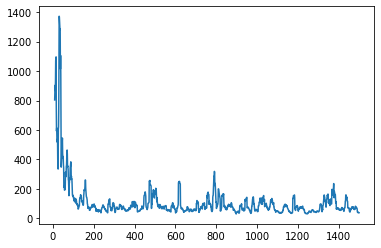

In [1124]:
series = pd.Series(results)
windows = series.rolling(10).mean()
plt.plot(windows)